# Quantifying semisc similarity
## Chapter X: Data sequence analysis patches 

### Author: Anders Kampenes

### Dimension reduction and visualization with PCA

In [1]:
### Fetched from https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoderimport numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

import numpy as np
import pandas as pd
K.clear_session()

np.random.seed(237)

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
### A. Load Data

In [39]:
import sys, os
from os.path import join, basename, dirname, exists
sys.path.insert(0, os.path.abspath('..'))
# declare parent dir name 
dirname = sys.path[0] # parent directory

train_orig = pd.read_csv(join(dirname, 'data/processed/train.csv'))
test_orig = pd.read_csv(join(dirname, 'data/processed/test.csv'))

# only labes from 0 and 1 
train_orig = train_orig[(train_orig.label == 0) | (train_orig.label == 1)]
#test_orig.head()
train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
### B. Combine Train & Test

In [41]:
# create 'label' column in test dataset; rearrange so that columns are in the same order as in train
test_orig['label'] = 11
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test_orig = test_orig[testCols]

In [42]:
combined = pd.concat([train_orig, test_orig], ignore_index = True)

combined.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
combined.tail()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
36811,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36812,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36813,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36814,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36815,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# C. Split into training & validation sets¶


In [45]:
#Hold out 5000 random images as a validation/test sample
valid = combined.sample(n = 5000, random_state = 555)
train = combined.loc[~combined.index.isin(valid.index)]

# free up some space and delete test and combined
del train_orig, test_orig, combined

valid.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
17986,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2259,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27815,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
### 4. Reshape & normalize


In [47]:
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)

IndexError: index 42013 is out of bounds for axis 0 with size 31816

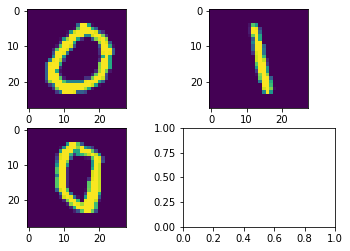

In [48]:
# We can take a look at a few random images. 
# The bottom right panel shows one of the more difficult-to-classify digits (even for humans!).
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

In [49]:
# 3. Model construction


In [50]:
### A. Encoder network


In [51]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [52]:
### B. Sampling function

In [53]:
# sampling function 
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [54]:
### C. Decoder network

In [55]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [56]:
### D. Loss
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [57]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (None, 28, 28, 32)    320         input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                (None, 14, 14, 64)    18496       conv2d_6[0][0]                   
____________________________________________________________________________________________________
conv2d_8 (Conv2D)                (None, 14, 14, 64)    36928       conv2d_7[0][0]                   
___________________________________________________________________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=1,
        batch_size=batch_size,
        validation_data=(X_valid, None))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 31816 samples, validate on 5000 samples
Epoch 1/1
31816/31816 [==============================] - 170s - loss: 0.2069 - val_loss: 0.1922


In [58]:
# store model 
# serialize weights to HDF5
filename ="/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/visualizing-mnist-VAE-rieman_latent_space"+"/model_0_1.h5"
#vae.save_weights(filename)
#print("Saved model to disk")

vae.load_weights(filename)


In [59]:
# 5. Results


In [60]:
# Isolate original training set records in validation set
valid_noTest = valid[valid['label'] != 11]

# X's and Y's
X_valid_noTest = valid_noTest.drop('label', axis=1)
y_valid_noTest = valid_noTest['label']

# Reshape and normalize
X_valid_noTest = X_valid_noTest.astype('float32') / 255.
X_valid_noTest = X_valid_noTest.values.reshape(-1,28,28,1)

Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1530, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotli

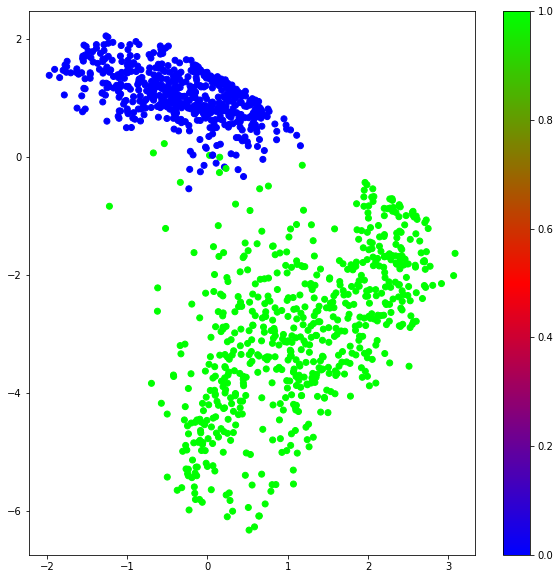

In [69]:
# Translate into the latent space  by plotting the MEAN
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(X_valid_noTest, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_valid_noTest, cmap='brg')
plt.colorbar()
plt.show()

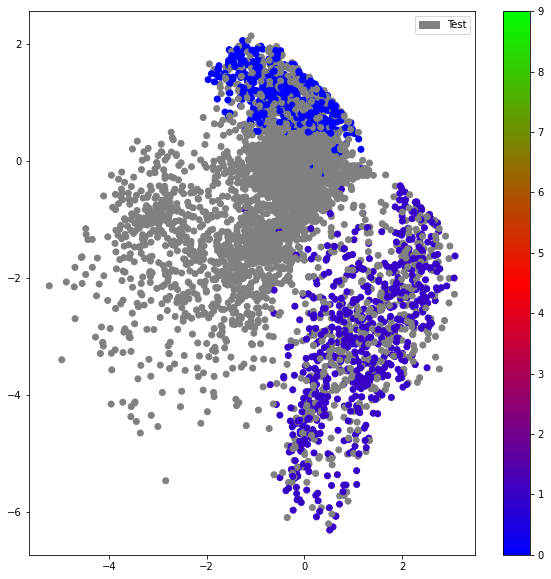

In [62]:
# set colormap so that 11's are gray
custom_cmap = matplotlib.cm.get_cmap('brg')
custom_cmap.set_over('gray')

x_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
gray_marker = mpatches.Circle(4,radius=0.1,color='gray', label='Test')
plt.legend(handles=[gray_marker], loc = 'best')
plt.scatter(x_valid_encoded[:, 0], x_valid_encoded[:, 1], c=y_valid, cmap=custom_cmap)
plt.clim(0, 9)
plt.colorbar()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1530, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotli

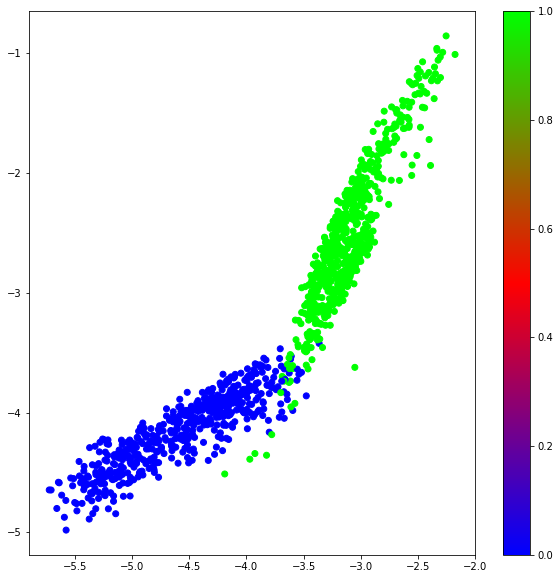

In [75]:
# we plot the VARIANCE 
# Translate into the latent space
encoder_zigma = Model(input_img, z_log_sigma)
x_valid_noTest_encoded_var = encoder_zigma.predict(X_valid_noTest, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded_var[:, 0], x_valid_noTest_encoded_var[:, 1], c=y_valid_noTest, cmap='brg')
plt.colorbar()
plt.show()


In [ ]:
#B. Sample digits


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1530, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotli

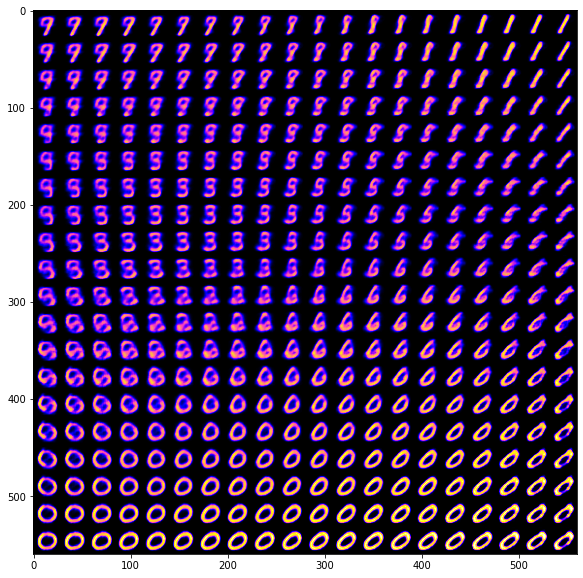

In [71]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  

In [65]:
# Now we have a vae, we can calculate the latent space riemann 

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from scripts.riemannian.riemannian_latent_space import RiemannianMetric, RiemannianTree
from keras.models import Sequential
from keras.layers import Dense, Input

import tensorflow as tf


In [66]:
z_sample = np.random.rand(100,2)
print("z_sampel", z_sample)
x_decoded = decoder.predict(z_sample, batch_size=batch_size)
print("x_decoded.shape", x_decoded.shape)
#plt.imshow(np.squeeze(x_decoded))
#decoder.summary()
model_input = decoder.inputs[0]
model_output = decoder.outputs[0]
print(model_input, model_output)
print(model_input[:,0], model_output)

output_dim = model_output.shape[1]
print("output_dim", model_output.shape[1])
J=[tf.gradients(model_output[:, _], model_input)[0] for _ in range(28)]
#print(J)
J = tf.stack(J, axis=1)  # batch x output x latent
print("")
print("Done")
print("")
session = tf.Session()
session.run(tf.global_variables_initializer())
rmetric = RiemannianMetric(x=model_output, z=model_input, session=session)
rmetric.create_tf_graph()
print("doneee") 




z_sampel [[0.61238786 0.78685339]
 [0.82956853 0.36164713]
 [0.61587404 0.7480705 ]
 [0.60762026 0.41271084]
 [0.03884925 0.73152535]
 [0.25726881 0.29039696]
 [0.22343563 0.18429683]
 [0.52441466 0.44801961]
 [0.67621739 0.10217949]
 [0.29511535 0.32812327]
 [0.40360102 0.51778616]
 [0.08955018 0.51743064]
 [0.845092   0.54493715]
 [0.45311295 0.92307339]
 [0.5128952  0.72219235]
 [0.0268146  0.02203625]
 [0.02731819 0.57776768]
 [0.32131356 0.54901945]
 [0.29740357 0.56694153]
 [0.83717791 0.57144158]
 [0.19254214 0.51037779]
 [0.03515548 0.11294625]
 [0.63299227 0.24840017]
 [0.97749855 0.30565094]
 [0.42474102 0.39428079]
 [0.67638308 0.35323239]
 [0.50500931 0.69918499]
 [0.55873934 0.91210972]
 [0.13365211 0.24320812]
 [0.1966897  0.72077139]
 [0.34655689 0.15430183]
 [0.94314163 0.74164704]
 [0.96079114 0.7539519 ]
 [0.35884364 0.1673831 ]
 [0.63767147 0.42623865]
 [0.39629279 0.24376598]
 [0.15347317 0.31801667]
 [0.23776095 0.9167112 ]
 [0.02328271 0.91583608]
 [0.65283078 0.5

(13455, 2)
mf grid (13455,)
(117, 115) (117, 115) (13455,)


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1530, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotli

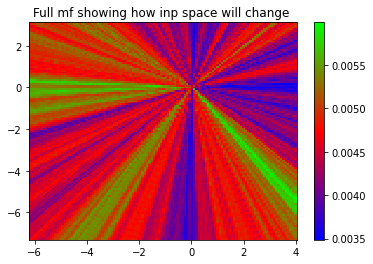

In [67]:
# plot mf for entire grid 
h = .09  # step size in the mesh
x_min, x_max = x_valid_encoded[:, 0].min() - 1, x_valid_encoded[:, 0].max() + 1
y_min, y_max = x_valid_encoded[:, 1].min() - 1,x_valid_encoded[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

grid_inp = np.c_[xx.ravel(), yy.ravel()]   
print(grid_inp.shape)

mf = session.run(rmetric.MF, {rmetric.z: grid_inp})
print("mf grid", mf.shape)
print(xx.shape, yy.shape, mf.shape)
# Put the result into a color plot
Z = mf.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap="brg")

#plot actuals
plt.title("Full mf showing how inp space will change ")
plt.colorbar()
plt.show()

images.shape (7, 28, 28)


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1530, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotli

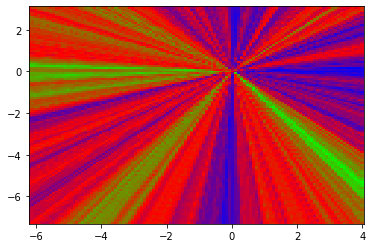

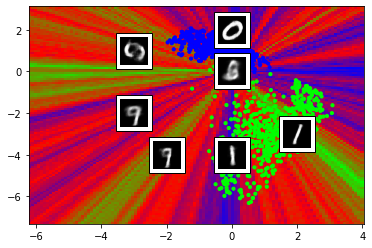

In [73]:
# plot random images in the space 
z_samples = np.asarray([[-3,-2],[-3,1],[0,2],[0,0],[-2,-4],[0,-4], [2,-3]])
images = np.squeeze(decoder.predict(z_samples))
print("images.shape", images.shape)
plt.pcolormesh(xx, yy, Z, cmap="brg")


plt.figure()
plt.pcolormesh(xx, yy, Z, cmap="brg")
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_valid_noTest, cmap=custom_cmap, s=10)


from matplotlib import offsetbox

def plot_components(proj, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(proj.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i].T, cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
            
            
plot_components(proj=z_samples,images=[np.reshape(i, (28, 28)).T for i in images])







In [ ]:

model_input = decoder_zigma.inputs[0]
model_output = decoder_zigma.outputs[0]
print(model_input, model_output)
print(model_input[:,0], model_output)

output_dim = model_output.shape[1]
print("output_dim", model_output.shape[1])
J=[tf.gradients(model_output[:, _], model_input)[0] for _ in range(28)]
#print(J)
J = tf.stack(J, axis=1)  # batch x output x latent
print("")
print("Done")
print("")
session = tf.Session()
session.run(tf.global_variables_initializer())
rmetric = RiemannianMetric(x=model_output, z=model_input, session=session)
rmetric.create_tf_graph()
print("doneee") 

In [ ]:
# plot mf for entire grid 
h = .09  # step size in the mesh
x_min, x_max = x_valid_encoded[:, 0].min() - 1, x_valid_encoded[:, 0].max() + 1
y_min, y_max = x_valid_encoded[:, 1].min() - 1,x_valid_encoded[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

grid_inp = np.c_[xx.ravel(), yy.ravel()]   
print(grid_inp.shape)

mf = session.run(rmetric.MF, {rmetric.z: grid_inp})
print("mf grid", mf.shape)
print(xx.shape, yy.shape, mf.shape)
# Put the result into a color plot
Z = mf.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap="brg")

#plot actuals
plt.title("Full mf showing how inp space will change ")
plt.colorbar()
plt.show()

[ 1.64485363  1.29669299  1.05927692  0.87016448  0.7079966   0.56263389
  0.42831603  0.30133652  0.17905472  0.05940243 -0.05940243 -0.17905472
 -0.30133652 -0.42831603 -0.56263389 -0.7079966  -0.87016448 -1.05927692
 -1.29669299 -1.64485363]
[-1.64485363 -1.29669299 -1.05927692 -0.87016448 -0.7079966  -0.56263389
 -0.42831603 -0.30133652 -0.17905472 -0.05940243  0.05940243  0.17905472
  0.30133652  0.42831603  0.56263389  0.7079966   0.87016448  1.05927692
  1.29669299  1.64485363]


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1530, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotli

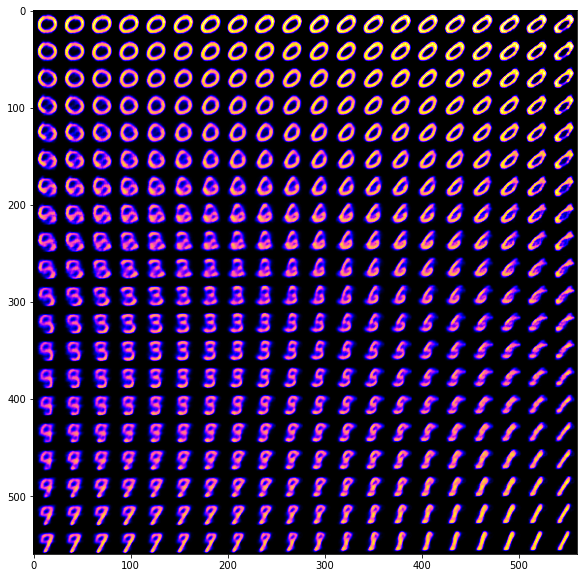

In [74]:


# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = np.flip(norm.ppf(np.linspace(0.05, 0.95, n)))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
print(grid_x)
print(grid_y)

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        #print("z_sample", xi, yi)
        #print("index", i * digit_size, (i + 1) * digit_size, j * digit_size, (j + 1) * digit_size)
        #print("")
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  